In [1]:
# Wether to download local copies of the PDB files or not
DOWNLOAD_PDBS = True

# Defines binding pocket as the residues with atoms within DISTANCE_THRESHOLD from the cocrystalized catecholamine
DISTANCE_THRESHOLD = 5  # angstroms

# ligand_names = ['PHE', 'PEA', '1WE', '3MT', 'TYR','AEF','OTR','DAH','LDP','LNR','ALE','YTX']
ligand_names = ['PHE', 'PEA', '1WE', '3MT', 'TYR','AEF','OTR','DAH','LDP','LNR','ALE','SYP', 'NMT']
ligand_names = sorted(ligand_names)

In [2]:
from rcsbsearchapi.search import AttributeQuery

def get_pdb_ids_with_ligand(ligand_name: str) -> list[str]:
    """Queries the RCSB PDB for PDB IDs that have the given 3-letter code as a standalone ligand.
    
        The structure of the query was taken from a manual query in the RCSB website and turned into the API syntax.

        Args:
            ligand_name: 
                The 3-letter code of the ligand. 

        Returns:
            A list of PDB IDs that have the given ligand.
    """
    q1 = AttributeQuery(
        attribute="rcsb_nonpolymer_entity_instance_container_identifiers.comp_id", operator="exact_match", value=ligand_name,
    )
    q2 = AttributeQuery(
        attribute="rcsb_nonpolymer_instance_feature_summary.comp_id", operator="exists", negation=True,
    )
    q3 = AttributeQuery(
        attribute="rcsb_nonpolymer_instance_feature_summary.comp_id", operator="exact_match", value=ligand_name, negation=True,
    )
    q4 = AttributeQuery(
        attribute="rcsb_nonpolymer_instance_feature_summary.type", operator="exact_match", value="HAS_COVALENT_LINKAGE", negation=True,
    )

    query = q1 & (q2 | q3 | q4)
    results = query.exec()
    return list(results)

results = get_pdb_ids_with_ligand(ligand_name="LNR")

In [3]:
# query the PDBs of with each cathecolamine (as a standalone ligand) and get the PDB IDs
pdb_ids: dict[str, list[str]] = {}
n = 0
for ligand_name in ligand_names:
    results = get_pdb_ids_with_ligand(ligand_name=ligand_name)
    pdb_ids[ligand_name] = results
    n += len(results)
    print(ligand_name, len(results))

# note that some PDBs have an entry in RCSB but the structure doesn't exist according to Bio.PDB (e.g., 5o61)
# these will be caught when trying to read the downloaded PDB files.
# it only seems to be a problem for a handful of PHE PDBs
# the total number of structures analyzed should be fetched from the number of structures loaded
print("Total:", n)  
print(pdb_ids) 

1WE 3
3MT 1
AEF 4
ALE 6
DAH 6
LDP 24
LNR 7
NMT 0
OTR 6
PEA 13
PHE 95
SYP 0
TYR 72
Total: 237
{'1WE': ['4LAR', '4XP9', '8JSO'], '3MT': ['1AEB'], 'AEF': ['3BRA', '4N7C', '5FF9', '8EEK'], 'ALE': ['2HKK', '4A7U', '4LDO', '7BRN', '7BTS', '8THL'], 'DAH': ['3TEG', '3TEH', '4P6S', '6JU9', '6ON3', '6PAH'], 'LDP': ['2A3R', '2QMZ', '2VQ5', '3NK2', '4A7V', '4DTZ', '4DU2', '4DUB', '5LOG', '5PAH', '5PHH', '6DYO', '6ZN2', '7CKZ', '7F0T', '7F1O', '7F1Z', '7F23', '7F24', '7LJD', '7PIM', '7X2F', '8EEG', '8EEJ'], 'LNR': ['2QEO', '3DYE', '3HCD', '4PAH', '4Y4J', '6M0Z', '6M2R'], 'NMT': [], 'OTR': ['1RG2', '1RGT', '2AN4', '3HCA', '3HCE', '8EEF'], 'PEA': ['1D6U', '1D6Y', '1D6Z', '1TNJ', '1UTM', '1UTO', '5GI6', '8IW7', '8IWM', '8J6G', '8W89', '8WC6', '8WCA'], 'PHE': ['1AMU', '1B70', '1C1D', '1F2P', '1I7A', '1IS7', '1IS8', '1KFL', '1OFR', '1OG0', '1USI', '2EFU', '2FMG', '2JB2', '2QMX', '2VBW', '2YPO', '2Z3O', '3AYJ', '3B34', '3BWN', '3CMA', '3CME', '3KGF', '3L4G', '3LKV', '3MK2', '3MWB', '3NUD', '3PCO', '3RZI'

In [4]:
# optionally download the PDB files if they are not already present in the pdbs folder
from Bio.PDB import PDBList

pdb_list = PDBList()
if DOWNLOAD_PDBS:
    for ligand_name, ids in pdb_ids.items():
        for pdb_id in ids:
            pdb_list.retrieve_pdb_file(pdb_id, pdir=f"./pdbs/{ligand_name}", file_format="pdb")


Structure exists: './pdbs/1WE/pdb4lar.ent' 
Structure exists: './pdbs/1WE/pdb4xp9.ent' 
Structure exists: './pdbs/1WE/pdb8jso.ent' 
Structure exists: './pdbs/3MT/pdb1aeb.ent' 
Structure exists: './pdbs/AEF/pdb3bra.ent' 
Structure exists: './pdbs/AEF/pdb4n7c.ent' 
Structure exists: './pdbs/AEF/pdb5ff9.ent' 
Structure exists: './pdbs/AEF/pdb8eek.ent' 
Structure exists: './pdbs/ALE/pdb2hkk.ent' 
Structure exists: './pdbs/ALE/pdb4a7u.ent' 
Structure exists: './pdbs/ALE/pdb4ldo.ent' 
Structure exists: './pdbs/ALE/pdb7brn.ent' 
Structure exists: './pdbs/ALE/pdb7bts.ent' 
Structure exists: './pdbs/ALE/pdb8thl.ent' 
Structure exists: './pdbs/DAH/pdb3teg.ent' 
Structure exists: './pdbs/DAH/pdb3teh.ent' 
Structure exists: './pdbs/DAH/pdb4p6s.ent' 
Structure exists: './pdbs/DAH/pdb6ju9.ent' 
Structure exists: './pdbs/DAH/pdb6on3.ent' 
Structure exists: './pdbs/DAH/pdb6pah.ent' 
Structure exists: './pdbs/LDP/pdb2a3r.ent' 
Structure exists: './pdbs/LDP/pdb2qmz.ent' 
Structure exists: './pdbs/LDP/pd

In [5]:
# Load PDB files from ./pdbs/
from Bio.PDB import PDBParser
from Bio.PDB.Structure import Structure
from collections import defaultdict

found_structures: dict[str, list[str]] = defaultdict(list)
structures: dict[str, list[Structure]] = defaultdict(list)
parser = PDBParser(PERMISSIVE=True, QUIET=True)
for ligand_name, ids in pdb_ids.items():
    print(ligand_name)
    for pdb_id in ids:
        try:
            structure = parser.get_structure(pdb_id, f"./pdbs/{ligand_name}/pdb{pdb_id.lower()}.ent")
            found_structures[ligand_name].append(pdb_id)
            structures[ligand_name].append(structure)
        except FileNotFoundError:
            print(f"Could not read {pdb_id}. Probably becaus Bio.PDB couldn't download it.")
    print(f"Loaded {len(structures[ligand_name])} structures")

print("Total structures loaded:", sum(len(v) for v in structures.values()))

1WE
Loaded 3 structures
3MT
Loaded 1 structures
AEF
Loaded 4 structures
ALE
Loaded 6 structures
DAH
Loaded 6 structures
LDP
Loaded 24 structures
LNR
Loaded 7 structures
NMT
Loaded 0 structures
OTR
Loaded 6 structures
PEA
Loaded 13 structures
PHE
Could not read 5O61. Probably becaus Bio.PDB couldn't download it.
Could not read 5WDT. Probably becaus Bio.PDB couldn't download it.
Could not read 5WE4. Probably becaus Bio.PDB couldn't download it.
Could not read 5WE6. Probably becaus Bio.PDB couldn't download it.
Could not read 5WF0. Probably becaus Bio.PDB couldn't download it.
Could not read 5WFK. Probably becaus Bio.PDB couldn't download it.
Could not read 5WFS. Probably becaus Bio.PDB couldn't download it.
Loaded 88 structures
SYP
Loaded 0 structures
TYR
Loaded 72 structures
Total structures loaded: 230


In [6]:
for ligand_name in ligand_names:
    print(ligand_name, len(found_structures[ligand_name]))
    print(", ".join(found_structures[ligand_name]))

1WE 3
4LAR, 4XP9, 8JSO
3MT 1
1AEB
AEF 4
3BRA, 4N7C, 5FF9, 8EEK
ALE 6
2HKK, 4A7U, 4LDO, 7BRN, 7BTS, 8THL
DAH 6
3TEG, 3TEH, 4P6S, 6JU9, 6ON3, 6PAH
LDP 24
2A3R, 2QMZ, 2VQ5, 3NK2, 4A7V, 4DTZ, 4DU2, 4DUB, 5LOG, 5PAH, 5PHH, 6DYO, 6ZN2, 7CKZ, 7F0T, 7F1O, 7F1Z, 7F23, 7F24, 7LJD, 7PIM, 7X2F, 8EEG, 8EEJ
LNR 7
2QEO, 3DYE, 3HCD, 4PAH, 4Y4J, 6M0Z, 6M2R
NMT 0

OTR 6
1RG2, 1RGT, 2AN4, 3HCA, 3HCE, 8EEF
PEA 13
1D6U, 1D6Y, 1D6Z, 1TNJ, 1UTM, 1UTO, 5GI6, 8IW7, 8IWM, 8J6G, 8W89, 8WC6, 8WCA
PHE 88
1AMU, 1B70, 1C1D, 1F2P, 1I7A, 1IS7, 1IS8, 1KFL, 1OFR, 1OG0, 1USI, 2EFU, 2FMG, 2JB2, 2QMX, 2VBW, 2YPO, 2Z3O, 3AYJ, 3B34, 3BWN, 3CMA, 3CME, 3KGF, 3L4G, 3LKV, 3MK2, 3MWB, 3NUD, 3PCO, 3RZI, 3TCY, 3TD9, 3TK2, 4D2C, 4FXJ, 4IO7, 4JPX, 4JPY, 4PPV, 4TVA, 4UC5, 4UC8, 4UC9, 4XN5, 5CKV, 5CKX, 5CZS, 5CZT, 5D04, 5D05, 5D58, 5D59, 5DCB, 5FII, 5MGH, 5MGU, 5MGW, 5NZK, 5OXN, 6D6N, 6EEI, 6GG4, 6GYP, 6UOB, 6VH5, 6W3V, 6XWM, 6YU3, 6Z80, 7AL9, 7ALB, 7ALC, 7ALZ, 7AM0, 7AQ0, 7AQ9, 7AQA, 7C3J, 7C4N, 7KA0, 7KAB, 7OEX, 7QRI, 7R3B, 7X5J, 8IH

In [8]:
import numpy as np
def extract_coords(model, ligname):
    """
    model is an object of type Model from the Bio.PDB library
    ligname is the residue name of the substrate in the read file
    Really intricate way of extracting the residue names of the crystal and the coordinates of the protein atoms
    """
    all_resids = [a.parent._id[1] for chain in model.get_chains()
                  for res in chain.get_residues() for a in res.get_atoms()]
    all_residues = [a.parent.resname for chain in model.get_chains(
    ) for res in chain.get_residues() for a in res.get_atoms()]
    all_coords = [a.coord for chain in model.get_chains()
                  for res in chain.get_residues() for a in res.get_atoms()]

    all_resids = np.array(all_resids)
    all_residues = np.array(all_residues)
    all_coords = np.array(all_coords)

    # print(np.sum(all_resids[all_residues==ligname]))
    lig_mask = np.logical_and(all_residues == ligname, all_resids == max(
        all_resids[all_residues == ligname]))
    apo_mask = np.invert(lig_mask)
    # print(max(all_resids[all_residues==ligname]))
    lig_coords = all_coords[lig_mask]
    apo_coords = all_coords[apo_mask]
    apo_residues = all_residues[apo_mask]
    apo_resids = all_resids[apo_mask]
    apo_residues = np.core.defchararray.add(
        apo_residues, apo_resids.astype(str))
    return lig_coords, apo_coords, apo_residues

In [9]:
# Extracts the residues in nearby the substrates of interest
from scipy.spatial.distance import cdist
binding_sites: dict[str, list[str]] = defaultdict(list)

for ligand_name, structures_for_lig in structures.items():
    print(ligand_name)
    for structure in structures_for_lig:
        print(structure.id)
        lig_coords, apo_coords, apo_residues = extract_coords(list(structure.get_models())[0], ligand_name)
        dists = cdist(lig_coords, apo_coords)
        near_residues = apo_residues[np.where(dists < DISTANCE_THRESHOLD)[1]]
        near_residues = np.unique(near_residues)
        # print(s, st.id, len(near_residues))#, near_residues)
        binding_sites[ligand_name] += [res[:3] for res in near_residues]

1WE
4LAR
4XP9
8JSO
3MT
1AEB
AEF
3BRA
4N7C
5FF9
8EEK
ALE
2HKK
4A7U
4LDO
7BRN
7BTS
8THL
DAH
3TEG
3TEH
4P6S
6JU9
6ON3
6PAH
LDP
2A3R
2QMZ
2VQ5
3NK2
4A7V
4DTZ
4DU2
4DUB
5LOG
5PAH
5PHH
6DYO
6ZN2
7CKZ
7F0T
7F1O
7F1Z
7F23
7F24
7LJD
7PIM
7X2F
8EEG
8EEJ
LNR
2QEO
3DYE
3HCD
4PAH
4Y4J
6M0Z
6M2R
NMT
OTR
1RG2
1RGT
2AN4
3HCA
3HCE
8EEF
PEA
1D6U
1D6Y
1D6Z
1TNJ
1UTM
1UTO
5GI6
8IW7
8IWM
8J6G
8W89
8WC6
8WCA
PHE
1AMU
1B70
1C1D
1F2P
1I7A
1IS7
1IS8
1KFL
1OFR
1OG0
1USI
2EFU
2FMG
2JB2
2QMX
2VBW
2YPO
2Z3O
3AYJ
3B34
3BWN
3CMA
3CME
3KGF
3L4G
3LKV
3MK2
3MWB
3NUD
3PCO
3RZI
3TCY
3TD9
3TK2
4D2C
4FXJ
4IO7
4JPX
4JPY
4PPV
4TVA
4UC5
4UC8
4UC9
4XN5
5CKV
5CKX
5CZS
5CZT
5D04
5D05
5D58
5D59
5DCB
5FII
5MGH
5MGU
5MGW
5NZK
5OXN
6D6N
6EEI
6GG4
6GYP
6UOB
6VH5
6W3V
6XWM
6YU3
6Z80
7AL9
7ALB
7ALC
7ALZ
7AM0
7AQ0
7AQ9
7AQA
7C3J
7C4N
7KA0
7KAB
7OEX
7QRI
7R3B
7X5J
8IHR
8P8X
SYP
TYR
1J1U
1S2K
1TYA
1TYB
1TYD
1WQ4
1X8X
1Y42
2AMC
2CSM
2CYB
2CYC
2PV7
2QAA
2VBY
2WHZ
2XII
2YPP
2YPQ
3B37
3GGG
3KDZ
3MO4
3O7B
3PG9
4CSM
4GRS
4HSO
4OJM
4OUD
4P6R
4PP

In [10]:
# Prints non-standard residues to check if we are missing anything
aa_names: list[str] = ['ASP', 'ARG', 'LYS', 'HIS', 'GLU', 'GLN', 'SER', 'ASN', 'THR',
            'PHE', 'TRP', 'TYR', 'ALA', 'LEU', 'ILE', 'MET', 'VAL', 'GLY', 'PRO', 'CYS']
frequencies: dict[str, int] = {aa: 0 for aa in aa_names}
for ligand_name in ligand_names:
    labels, freqs = np.unique(binding_sites[ligand_name], return_counts=True)
    for lab, freq in zip(labels, freqs):
        try:
            frequencies[lab] += freq
        except:
            print("Strange residue: {}".format(lab))
print(frequencies)

Strange residue: HOH
Strange residue: NA7
Strange residue: HEM
Strange residue: HOH
Strange residue: FAD
Strange residue: HOH
Strange residue: NAP
Strange residue: HOH
Strange residue: CU5
Strange residue: FE2
Strange residue: FE4
Strange residue: HOH
Strange residue: ZN3
Strange residue: A3P
Strange residue: FAD
Strange residue: FE4
Strange residue: FE5
Strange residue: HBA
Strange residue: HEM
Strange residue: HOH
Strange residue: MG1
Strange residue: MSE
Strange residue: SAH
Strange residue: DMS
Strange residue: FE4
Strange residue: HOH
Strange residue: NA7
Strange residue: SAH
Strange residue: DA8
Strange residue: DC8
Strange residue: FAD
Strange residue: HOH
Strange residue: OTS
Strange residue: SAH
Strange residue: VO4
Strange residue: COA
Strange residue: HOH
Strange residue: TYQ
Strange residue: AMP
Strange residue: BA3
Strange residue: EDO
Strange residue: FAD
Strange residue: GOL
Strange residue: HOH
Strange residue: LLP
Strange residue: MG5
Strange residue: MSE
Strange resid

/var/folders/rx/y661s_v17xsf84wp1l5rc16h0000gn/T/ipykernel_26374/2706559107.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([k[0]+k[1:].lower()


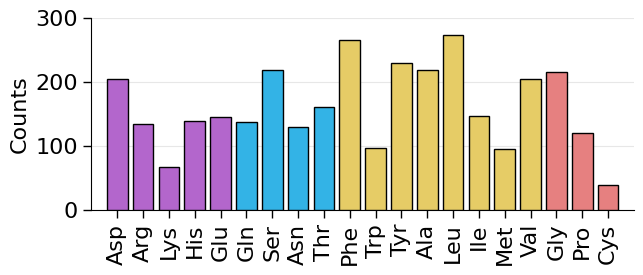

In [11]:
import matplotlib.pyplot as plt
FONT_SIZE = 16
# Plot frequency of each amino acid in all the crystals analyzed
c_charge = [(0.7, 0.4, 0.8)]*5
c_polar = [(0.2, 0.7, 0.9)]*4
c_phobic = [(0.9, 0.8, 0.4)]*8
c_special = [(0.9, 0.5, 0.5)]*3
colors = c_charge + c_polar + c_phobic + c_special

fig, ax = plt.subplots(figsize=(7, 2.5))
ax.tick_params(labelsize=FONT_SIZE, size=6, width=1.)
ax.set_ylim(0, 300)
ax.set_xlim(-1, 20)
ax.grid(alpha=0.3, zorder=1)
ax.set_xticklabels([k[0]+k[1:].lower()
                   for k in frequencies.keys()], rotation=90)
# ax.set_xlabel("Amino acid", fontsize=FONT_SIZE)
ax.set_ylabel("Counts", fontsize=FONT_SIZE)
ax.bar(frequencies.keys(), frequencies.values(),
       zorder=3, color=colors, edgecolor='k', lw=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(axis="x")
plt.savefig("bindingsites.png", format='png', dpi=300, bbox_inches='tight')
plt.savefig("bindingsites.svg", format='svg', bbox_inches='tight')
# plt.savefig("bindingsites.svg", format='svg', bbox_inches='tight')
# svg2emf("bindingsites.svg")
plt.show()
plt.close()

In [17]:
sorted_keys = sorted(frequencies.keys(), key=lambda x: frequencies[x], reverse=True)
for key in sorted_keys:
    if key not in ["ASP", "GLU", "HIS", "LYS", "ARG"]:
        print(key, frequencies[key])

LEU 273
PHE 265
TYR 230
SER 218
ALA 218
GLY 215
VAL 204
THR 161
ILE 147
GLN 138
ASN 130
PRO 120
TRP 97
MET 95
CYS 40


In [ ]:
# This is just a mini script to see how the total number of amino acid combinations is reduced as more conditions are imposed

import itertools


def filter_q(aa):
    aa_comb = list(itertools.product(aa, repeat=3))
    N = 0
    for a1, a2, a3 in aa_comb:
        Q = charges.get(a1, 0) + charges.get(a2, 0) + charges.get(a3, 0)
        if Q == -1 and a3 == "ASP" and charges.get(a1, 0) == 0 and charges.get(a2, 0) == 0:
            N += 1
    return N


AA = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HID', 'HIE', 'HIP',
      'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
charges = {'ARG': 1, 'LYS': 1, 'HIP': 1, 'ASP': -1, 'GLU': -1}
A3 = list(itertools.product(AA, repeat=3))
n3 = len(A3)
print(n3)

# These residues would result in too polar or synthetically complicated nanoparticles
AA.remove("HID")
AA.remove("HIE")
AA.remove("CYS")
# Glu is excluded because for redundancy with Asp
AA.remove("GLU")
# The next 4 are excluded for redundancy with other amino acids already included
AA.remove("MET")
AA.remove("VAL")
AA.remove("THR")
AA.remove("ASN")
print(filter_q(AA))

10648
100
